In [ ]:
import pandas as pd
import numpy as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow
import os

In [ ]:
import keras
(x_train, y_train), (x_test, y_test)=keras.datasets.cifar10.load_data()

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
int(y_train[0][0])

6

Class no: 6


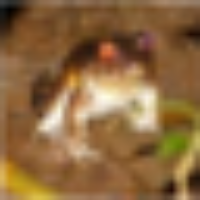

In [ ]:
smp = x_train[0]
smp_3ch = cv2.cvtColor(smp, cv2.COLOR_BGR2RGB)
smp_resized = cv2.resize(smp_3ch, (200,200))
print('Class no:',y_train[0][0])
cv2_imshow(smp_resized)

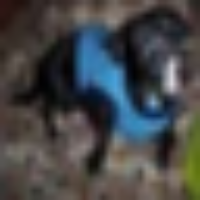

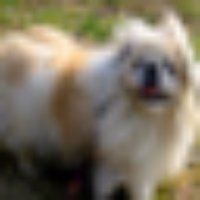

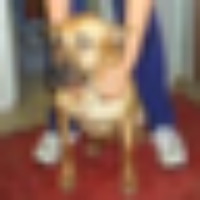

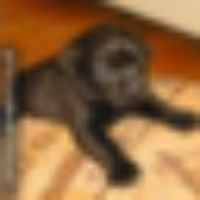

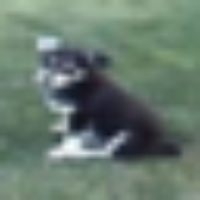

In [ ]:
counter = 0 # if counter ==5, then break
clas_no = 5 #class no 5 belongs to dog
for img,label in zip(x_train,y_train):
  if counter == 5:
    break
  else:
    if int(label[0]) == clas_no:
      counter += 1
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img_resized = cv2.resize(img, (200,200))
      cv2_imshow(img_resized)

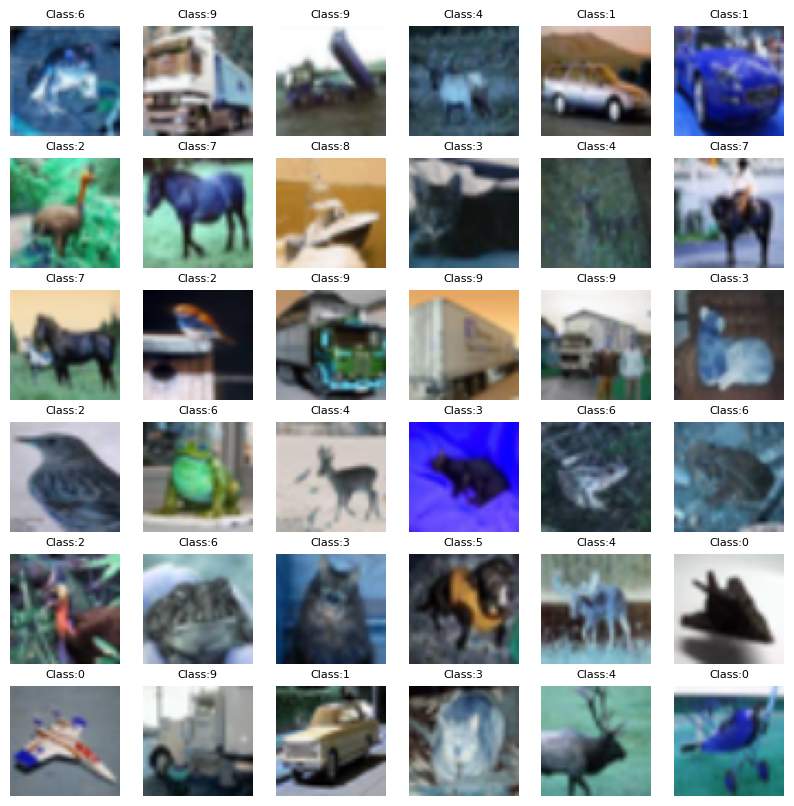

In [ ]:
#train images
fig,ax = plt.subplots(6,6,figsize=(10,10))
counter = 0
for img,label in zip(x_train,y_train):
  class_no = int(label[0])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img, (50,50))
  ax[counter//6][counter%6].imshow(img_resized)   #ax[0][0] to ax[6][6] --- 36 images
  ax[counter//6][counter%6].set_title('Class:'+str(class_no),fontsize = 8)
  ax[counter//6][counter%6].axis('off')
  counter += 1
  if counter == 36:
    break

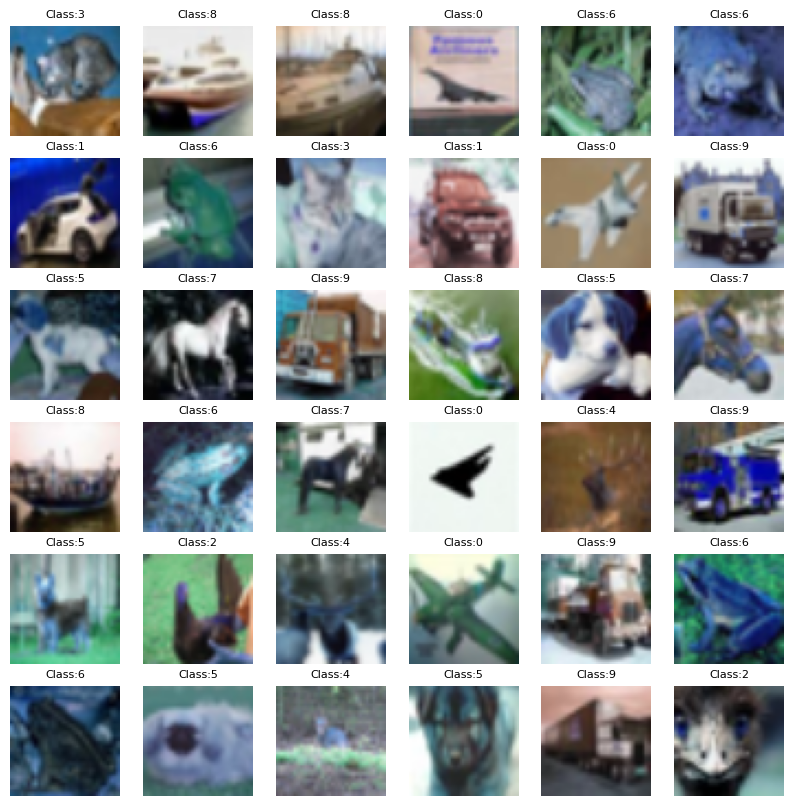

In [ ]:
#test images
fig,ax = plt.subplots(6,6,figsize=(10,10))
counter = 0
for img,label in zip(x_test,y_test):
  class_no = int(label[0])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img, (50,50))
  ax[counter//6][counter%6].imshow(img_resized)   #ax[0][0] to ax[6][6] --- 36 images
  ax[counter//6][counter%6].set_title('Class:'+str(class_no),fontsize = 8)
  ax[counter//6][counter%6].axis('off')
  counter += 1
  if counter == 36:
    break

## Pipeline for RESNET


For normalization value
> https://github.com/kuangliu/pytorch-cifar/issues/19#issue-268972488




In [ ]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]

In [ ]:
from torchvision import transforms

# -------- INFO --------
#Training pipeline focuses on augmentation + normalization.
#Testing pipeline focuses on standard preprocessing + normalization.'
# -------- INFO --------

#train pipeline for compose
#COMPOSE OF TRAIN AND TEST
#This is a pipeline where input data are being processed here

train_compose = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(0.1),
    transforms.ColorJitter(brightness= 0.1,contrast= 0.1,saturation= 0.1),
    transforms.RandomAdjustSharpness(sharpness_factor= 2,p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.RandomErasing(p = 0.75,
                             scale=(0.02,0.1),
                             value =1.0,
                             inplace=False)])

#no need to data augmentation in test so compose parameters are like this:
test_compose = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
])

In [ ]:
#https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

from torch.utils.data import Dataset, DataLoader

class ClassificationWithLabelDataset(Dataset):
    def __init__(self, img_labels, images, transform=None, target_transform=None):
        """
        Args:
            img_labels: A list or array of labels for the images.
            images: A list or array of images (e.g., numpy arrays or file paths).
            transform: A function/transform to apply to the images.
            target_transform: A function/transform to apply to the labels.
        """
        self.img_labels = img_labels
        self.images = images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)  # Number of samples in the dataset

    def __getitem__(self, idx):
        # Fetch the image and label for the given index
        image = self.images[idx]
        label = self.img_labels[idx]

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

# Assuming y_train and x_train are the labels and images respectively
train_data = ClassificationWithLabelDataset(y_train, x_train)
test_data = ClassificationWithLabelDataset(y_test, x_test)

In [ ]:
print('number of CPU core',os.cpu_count())
print('optimum value in num of worker:',torch.get_num_threads())

number of CPU core 2
optimum value in num of worker: 1


In [ ]:
# ---------------- INFO ----------------

#Shuffle:
#True: Randomly shuffles the data at the beginning of every epoch. This is crucial for training models to avoid learning patterns from the order of the data. ---> Recommended for train
#What if train shuffle is set as False, the same order in every epoch will be evaluated so the model wont learn anymore
#False: Loads data in sequential order (useful for evaluation or debugging). ---> Recommended for test
#Test will be give the same result for metric evaluation which is that it should be the same sequence so we can see it is improved or not


#num_workers: Parallelizes data loading to speed up the process. Each worker loads a portion of the dataset in parallel.
#Adjust based on your hardware and the dataset size. Too many workers can cause overhead or out-of-memory errors.

# ---------------- INFO ----------------


train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=1)


In [ ]:
#each batch packes 32 images with 32 labels!!!!!
for images, labels in train_dataloader:
    first_batch = images
    first_batch_labels = labels

    print(images.shape)  #expected to see only 32 images so [32,32,32,3] (32 times of 32x32 pixel in 3 channels)
    print(labels.shape)  #expected to see only 32 labels (32 times labels for each image)
    break #iterate for only one cycle

torch.Size([32, 32, 32, 3])
torch.Size([32, 1])


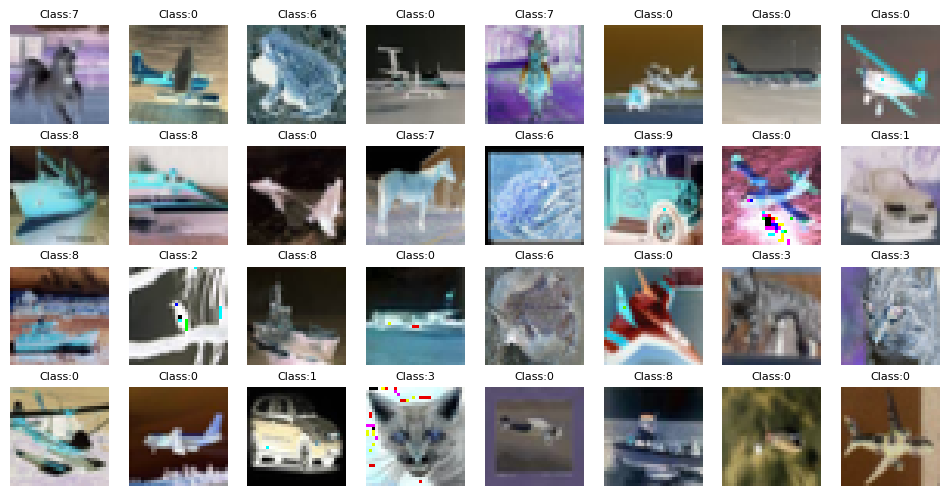

In [ ]:
fig, axes = plt.subplots(4,8,figsize=(12,6))

for idx, (img, label) in enumerate(zip(first_batch,first_batch_labels)):

  class_cifar = int(label)

  img = img.detach().cpu().numpy()
  image = (img * 255).astype('uint8')

  ax = axes[idx//8][idx%8]
  ax.imshow(image)
  ax.set_title('Class:'+str(class_cifar),fontsize = 8)
  ax.axis('off')
